In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Functions Used

In [85]:
def area_selection(dataframe, area):
    
    dataframe = dataframe[dataframe['City'] == area]
    
    
    return dataframe.rename(columns={"Date":"ds","Gross_Total":"y"})

In [86]:
def report_creator(dataframe, column_name, metric):
    lst = list()

    values_list = list(set(dataframe[column_name].to_list()))
    
    for value in values_list:
        lst.append(dataframe[dataframe[column_name] == value].groupby([column_name]).sum()[[metric]])
        df = pd.concat(lst)
        df = pd.DataFrame(df)
   
    return df.sort_values(by= metric, ascending=False)

In [112]:
def branch_report_creator(dataframe,branch_value):
    lst = list()

    values_list = list(set(dataframe['Branch'].to_list()))
    
    for value in values_list:
        
        if value == branch_value:
            lst.append(dataframe[dataframe['Branch'] == value].groupby('ds').sum())
            df = pd.concat(lst)
            df = pd.DataFrame(df)
   
    return df.sort_values(by= 'ds', ascending=True).reset_index()

# Load Data

In [25]:
sales_data = pd.read_csv(r'C:\Users\ranih\OneDrive\Desktop\Python For Real\Github\Data\Kaggle\Sales Data\supermarket_sales.csv')
sales_data.head(3)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4


In [26]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [27]:
sales_data.isnull().sum() # dataframe contains no missing values

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

# Preparing data for modeling

In [28]:
import datetime as dt
sales_data['ds'] = pd.to_datetime(sales_data['Date'])
sales_data['Time'] = pd.to_datetime(sales_data['Time'])

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Invoice ID               1000 non-null   object        
 1   Branch                   1000 non-null   object        
 2   City                     1000 non-null   object        
 3   Customer type            1000 non-null   object        
 4   Gender                   1000 non-null   object        
 5   Product line             1000 non-null   object        
 6   Unit price               1000 non-null   float64       
 7   Quantity                 1000 non-null   int64         
 8   Tax 5%                   1000 non-null   float64       
 9   Total                    1000 non-null   float64       
 10  Date                     1000 non-null   object        
 11  Time                     1000 non-null   datetime64[ns]
 12  Payment                  1000 non-n

In [29]:
sales_data = sales_data.assign(year=sales_data.ds.dt.year,
               month=sales_data.ds.dt.month,
               day=sales_data.ds.dt.day,
               Hour=sales_data.Time.dt.hour               ) 
sales_data.head(3)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,Payment,cogs,gross margin percentage,gross income,Rating,ds,year,month,day,Hour
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,...,Ewallet,522.83,4.761905,26.1415,9.1,2019-01-05,2019,1,5,13
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,...,Cash,76.40,4.761905,3.8200,9.6,2019-03-08,2019,3,8,10
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,...,Credit card,324.31,4.761905,16.2155,7.4,2019-03-03,2019,3,3,13


In [30]:
from dateutil import parser

day_of_week_lst = list()
for i in sales_data['Date'].values:
    day_of_week_lst.append(parser.parse(i).strftime("%A"))
    #print(parser.parse(i).strftime("%A"))
sales_data['day_of_week'] = day_of_week_lst
sales_data.head(3)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,cogs,gross margin percentage,gross income,Rating,ds,year,month,day,Hour,day_of_week
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,...,522.83,4.761905,26.1415,9.1,2019-01-05,2019,1,5,13,Saturday
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,...,76.40,4.761905,3.8200,9.6,2019-03-08,2019,3,8,10,Friday
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,...,324.31,4.761905,16.2155,7.4,2019-03-03,2019,3,3,13,Sunday


In [88]:
sales_data.loc[sales_data['day_of_week'] == 'Monday', 'day_of_week_number'] = 1
sales_data.loc[sales_data['day_of_week'] == 'Tuesday', 'day_of_week_number'] = 2
sales_data.loc[sales_data['day_of_week'] == 'Wednesday', 'day_of_week_number'] = 3
sales_data.loc[sales_data['day_of_week'] == 'Thursday', 'day_of_week_number'] = 4
sales_data.loc[sales_data['day_of_week'] == 'Friday', 'day_of_week_number'] = 5
sales_data.loc[sales_data['day_of_week'] == 'Saturday', 'day_of_week_number'] = 6
sales_data.loc[sales_data['day_of_week'] == 'Sunday', 'day_of_week_number'] = 7

In [89]:
sales_data.loc[sales_data['month'] == 1, 'month_name'] = 'Jan'
sales_data.loc[sales_data['month'] == 2, 'month_name'] = 'Feb'
sales_data.loc[sales_data['month'] == 3, 'month_name'] = 'March'

In [90]:
sales_data['Tax 5%'] = 1.05

In [91]:
sales_data['Total'] =  round((sales_data['Unit price'] * sales_data['Quantity']) * sales_data['Tax 5%'],2)

In [92]:
sales_data['income_after'] = round(((sales_data['Unit price'] * sales_data['Quantity'])  * sales_data['Tax 5%']) - sales_data['cogs'],2)

In [93]:
sales_data.loc[sales_data['Customer type'] == 'Member', 'member_count'] = 1
sales_data.loc[sales_data['Customer type'] == 'Normal', 'normal_count'] = 1
sales_data.fillna(0, inplace= True)
sales_data.head(3)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,year,month,day,Hour,day_of_week,day_of_week_number,month_name,income_after,member_count,normal_count
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,1.05,548.97,...,2019,1,5,13,Saturday,6.0,Jan,26.14,1.0,0.0
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,1.05,80.22,...,2019,3,8,10,Friday,5.0,March,3.82,0.0,1.0
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,1.05,340.53,...,2019,3,3,13,Sunday,7.0,March,16.22,0.0,1.0


In [94]:
sales_data.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating,year,month,day,Hour,day_of_week_number,income_after,member_count,normal_count
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.672130,5.510000,1.050000e+00,322.966930,307.58738,4.761905e+00,15.379369,6.97270,2019.0,1.993000,15.256000,14.910000,4.032000,15.379610,0.501000,0.499000
std,26.494628,2.923431,1.932755e-14,245.885478,234.17651,6.131498e-14,11.708825,1.71858,0.0,0.835254,8.693563,3.186857,1.973543,11.709043,0.500249,0.500249
min,10.080000,1.000000,1.050000e+00,10.680000,10.17000,4.761905e+00,0.508500,4.00000,2019.0,1.000000,1.000000,10.000000,1.000000,0.510000,0.000000,0.000000
25%,32.875000,3.000000,1.050000e+00,124.425000,118.49750,4.761905e+00,5.924875,5.50000,2019.0,1.000000,8.000000,12.000000,2.000000,5.920000,0.000000,0.000000
50%,55.230000,5.000000,1.050000e+00,253.850000,241.76000,4.761905e+00,12.088000,7.00000,2019.0,2.000000,15.000000,15.000000,4.000000,12.090000,1.000000,0.000000
75%,77.935000,8.000000,1.050000e+00,471.350000,448.90500,4.761905e+00,22.445250,8.50000,2019.0,3.000000,23.000000,18.000000,6.000000,22.445000,1.000000,1.000000
max,99.960000,10.000000,1.050000e+00,1042.650000,993.00000,4.761905e+00,49.650000,10.00000,2019.0,3.000000,31.000000,20.000000,7.000000,49.650000,1.000000,1.000000


In [32]:
# check the unique values of products and stores - want a single value
sales_data['Product line'].unique()

array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories'], dtype=object)

In [33]:
# check the unique values of products and stores - want a single value
sales_data['Branch'].unique()

array(['A', 'C', 'B'], dtype=object)

In [99]:
# the above to columns will be dropped when forcasting

In [98]:
prohet_sales_data = sales_data[['ds','Total','Branch']]
prohet_sales_data.rename(columns = {'Total':'y'}, inplace = True)
prohet_sales_data.sort_values(by='ds', inplace = True)
prohet_sales_data.reset_index(inplace=True, drop = True)
prohet_sales_data.head()

,ds,y,Branch
0,2019-01-01,177.41,B
1,2019-01-01,621.24,A
2,2019-01-01,399.76,A
3,2019-01-01,113.57,A
4,2019-01-01,132.03,C


In [125]:
prohet_sales_data_grp = prohet_sales_data.groupby('ds').sum()
prohet_sales_data_grp.reset_index(inplace=True)
prohet_sales_data_grp.head()

,ds,y
0,2019-01-01,4745.19
1,2019-01-02,1945.50
2,2019-01-03,2078.11
3,2019-01-04,1623.68
4,2019-01-05,3536.68


In [167]:
prohet_sales_data_grp.describe()

,y
count,89.000000
mean,3628.841910
std,1527.639468
min,934.250000
25%,2444.540000
50%,3163.250000
75%,4745.190000
max,7474.040000


In [168]:
branch_a_sales.describe()

,y
count,89.000000
mean,1193.262697
std,738.654911
min,156.100000
25%,598.080000
50%,1042.700000
75%,1674.270000
max,3254.480000


In [169]:
branch_b_sales.describe()

,y
count,86.000000
mean,1234.858488
std,896.780066
min,31.000000
25%,484.187500
50%,1029.570000
75%,1743.450000
max,3572.270000


In [170]:
branch_c_sales.describe()

,y
count,88.000000
mean,1256.462727
std,762.951052
min,38.850000
25%,642.980000
50%,1276.500000
75%,1645.887500
max,3632.880000


In [173]:
(1193.262697+1234.858488+1256.462727)/3

1228.1946373333333

In [113]:
branch_a_sales = branch_report_creator(prohet_sales_data, 'A')
branch_b_sales = branch_report_creator(prohet_sales_data, 'B')
branch_c_sales = branch_report_creator(prohet_sales_data, 'C')

In [160]:
print("Average sales - all branches")
print(prohet_sales_data_grp['y'].mean())

Average sales - all branches
3628.8419101123577


In [161]:
print("Average sales - Boston Branch")
print(branch_a_sales['y'].mean())

Average sales - Boston Branch
1193.2626966292137


In [162]:
print("Average sales - Denver Branch")
print(branch_b_sales['y'].mean())

Average sales - Denver Branch
1234.8584883720928


In [163]:
print("Average sales - Chicago Branch")
print(branch_c_sales['y'].mean())

Average sales - Chicago Branch
1256.4627272727269


# Train Model

In [136]:
model_all_branch = Prophet(interval_width = .95, daily_seasonality= True)
sales_forcasting_all_branch = model_all_branch.fit(prohet_sales_data_grp)

model_branch_a = Prophet(interval_width = .95, daily_seasonality= True)
sales_forcasting_branch_a = model_branch_a.fit(branch_a_sales)


model_branch_b = Prophet(interval_width = .95, daily_seasonality= True)
sales_forcasting_branch_b = model_branch_b.fit(branch_b_sales)


model_branch_c = Prophet(interval_width = .95, daily_seasonality= True)
sales_forcasting_branch_c = model_branch_c.fit(branch_c_sales)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# Forcasting

In [137]:
future_branch_all = model.make_future_dataframe(periods=14, freq='D')
forecast_branch_all = model_all_branch.predict(future_branch_all)
forecast_branch_all[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

future_branch_a = model.make_future_dataframe(periods=14, freq='D')
forecast_branch_a = model_branch_a.predict(future_branch_a)
forecast_branch_a[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

future_branch_b = model.make_future_dataframe(periods=14, freq='D')
forecast_branch_b = model_branch_b.predict(future_branch_b)
forecast_branch_b[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

future_branch_c = model.make_future_dataframe(periods=14, freq='D')
forecast_branch_c = model_branch_c.predict(future_branch_c)
forecast_branch_c[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
98,2019-04-09,1316.800287,-164.091946,2726.700754
99,2019-04-10,1323.558295,-82.087932,2806.873074
100,2019-04-11,1046.092742,-373.157339,2474.104297
101,2019-04-12,1202.615637,-184.782905,2595.513785
102,2019-04-13,1347.763981,37.123990,2792.843064


In [182]:
forecast_branch_a[['yhat']].tail(14).mean()

yhat    1193.797222
dtype: float64

In [183]:
forecast_branch_a[['yhat']].tail(14).sum()

yhat    16713.161103
dtype: float64

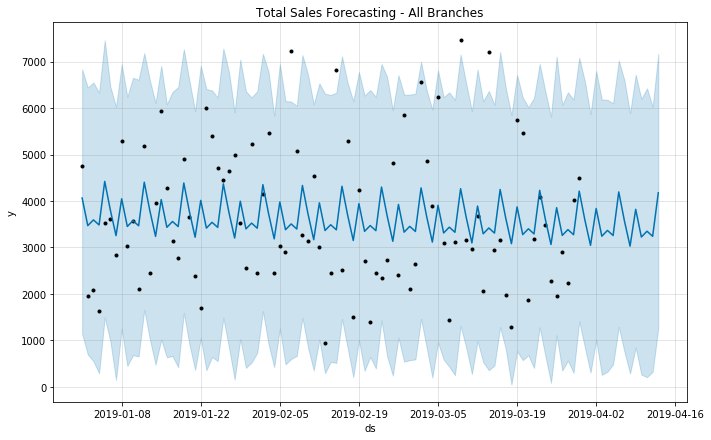

In [140]:
import matplotlib.pyplot as plt
from matplotlib import style

fig1_sales = model_all_branch.plot(forecast_branch_all,uncertainty=True)
plt.title("Total Sales Forecasting - All Branches")

plt.show()

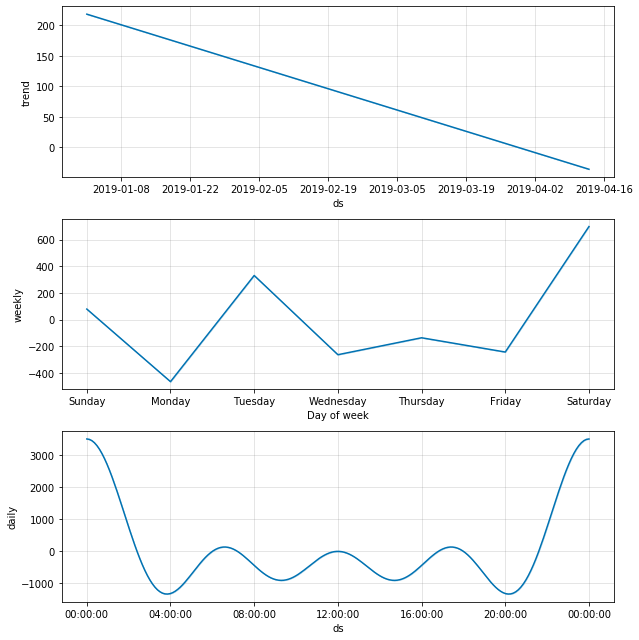

In [148]:
plt2 = model_all_branch.plot_components(forecast_branch_all)

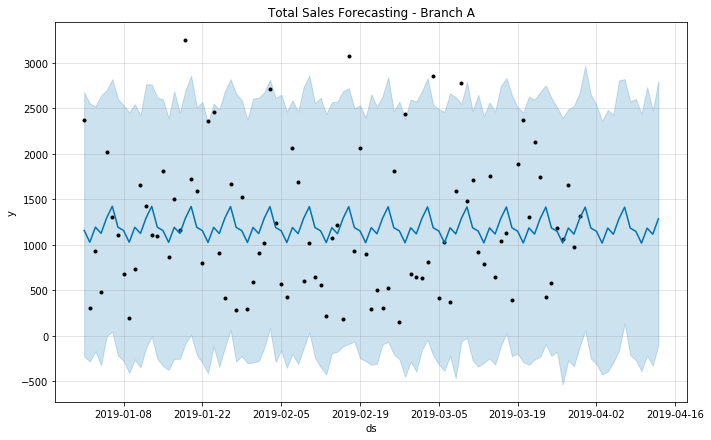

In [141]:
fig1_sales = model_branch_a.plot(forecast_branch_a,uncertainty=True)
plt.title("Total Sales Forecasting - Branch A")
plt.show()

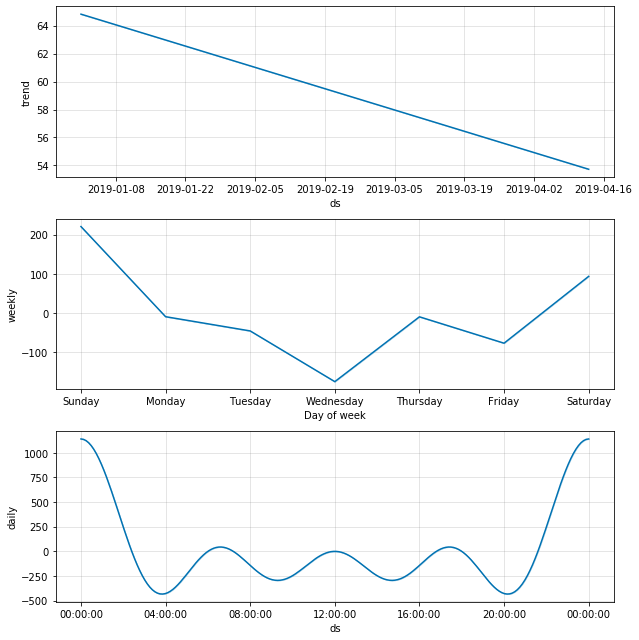

In [144]:
plt2 = model_branch_a.plot_components(forecast_branch_a)

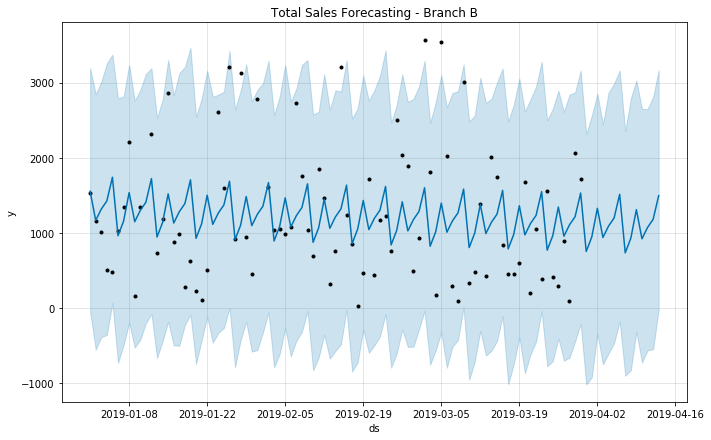

In [142]:
fig1_sales = model_branch_b.plot(forecast_branch_b,uncertainty=True)
plt.title("Total Sales Forecasting - Branch B")
plt.show()

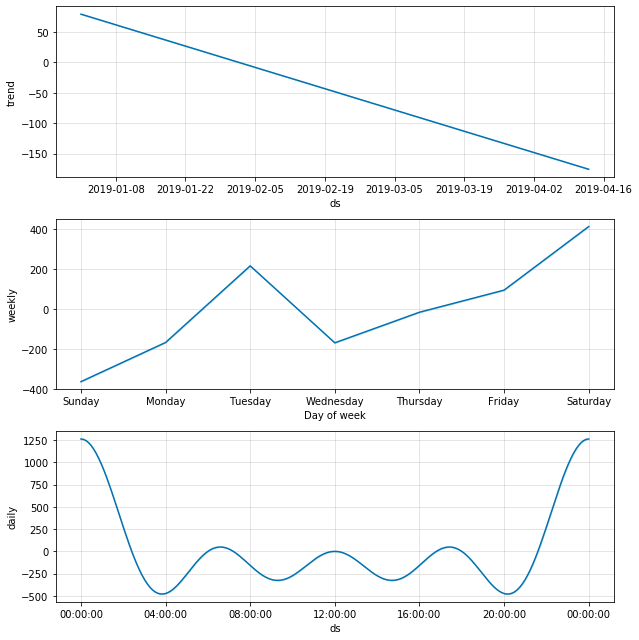

In [146]:
plt2 = model_branch_b.plot_components(forecast_branch_b)

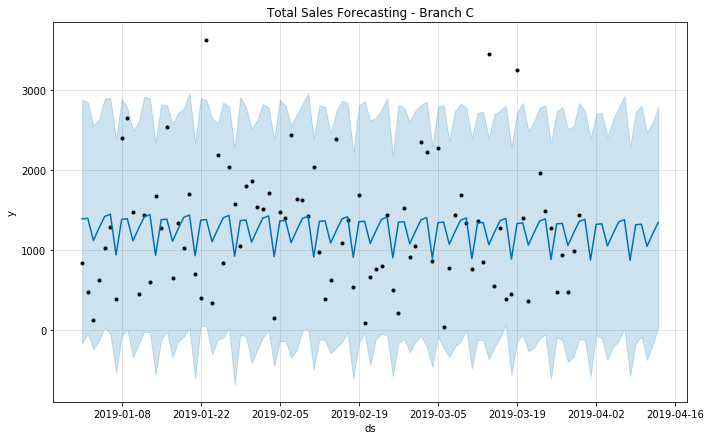

In [143]:
fig1_sales = model_branch_c.plot(forecast_branch_c,uncertainty=True)
plt.title("Total Sales Forecasting - Branch C")
plt.show()

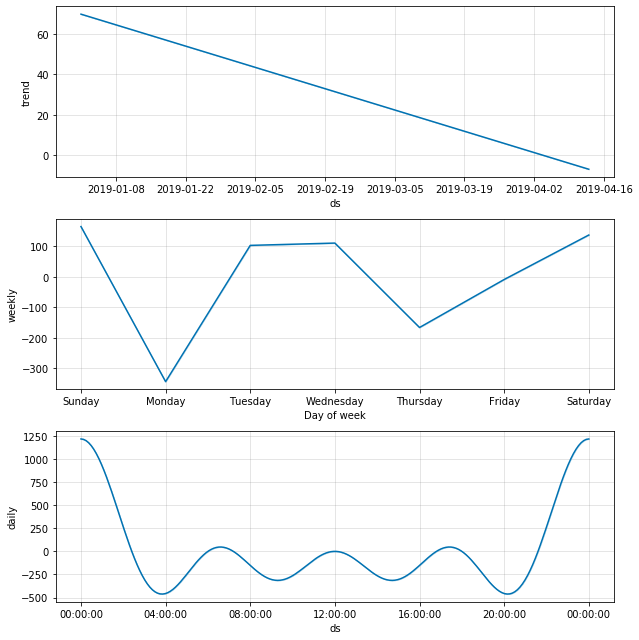

In [147]:
plt2 = model_branch_c.plot_components(forecast_branch_c)